In [67]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from funciones_aux import reemplazar_no, imprimir_resultados, guardar_resultado_en_csv, RUTA_TRAIN, RUTA_TEST

In [68]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [69]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [70]:
RUTA_GUARDADO = "NB.csv"

In [71]:
df_train = reemplazar_no(df_train)
df_test = reemplazar_no(df_test)

In [72]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [73]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [74]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [75]:
x_test = df_test["review_es"]

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
def busqueda_hiperparametros(modelo, x_vectorizado):
  param_grid = {
    "alpha": [0.65],
    "class_prior": [[0.1, 0.5]]
  }
  grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")

  grid_search.fit(x_vectorizado, y_train)

  return grid_search

In [78]:
def clean_text(text):
  return text.strip()

In [79]:
def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras

In [80]:
stoplist = stopwords.words("spanish")
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)
stoplist_tokenized = list(set(stoplist_tokenized))

In [81]:
vectorizer = CountVectorizer(preprocessor=clean_text,
                             tokenizer=tokenizer,
                             min_df=5,
                             stop_words=stoplist_tokenized) 
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

/home/taiel/.local/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Bernoulli Naive Bayes

In [82]:
# Dejando stopwords

nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros(nb_classifier, x_train_vec)

In [83]:
print(gs.best_params_)

{'alpha': 0.65, 'class_prior': [0.1, 0.5]}


In [84]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], class_prior=gs.best_params_["class_prior"])

In [85]:
best_nb.fit(x_train_vec, y_train)
y_pred = best_nb.predict(x_test_vec)

F1: 0.8422706176365584
Precision: 0.8722271517302573
Recall: 0.8143034654148833
Accuracy: 0.8471809062608094


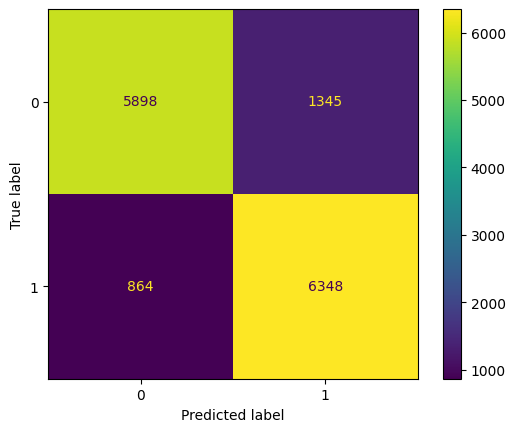

In [86]:
imprimir_resultados(y_test_, y_pred)

In [87]:
y_pred_ = best_nb.predict(vectorizer.transform(x_test))

In [88]:
guardar_resultado_en_csv(y_pred_, df_test, RUTA_GUARDADO)

In [89]:
## Testeo

In [90]:
pd.DataFrame(y_pred, columns=["Etiqueta_Predicha"])
pd.DataFrame({"review_es": x_test})
pd.DataFrame({"review_es": y_test_})


,review_es
32699,1
29345,1
24750,0
25119,1
40318,0
...,...
12016,0
35444,0
9162,1
29445,1


In [91]:
a = pd.DataFrame({"review_es": x_test_})
a.reset_index(drop=True, inplace=True)

In [92]:
b = pd.DataFrame({"sentimiento": y_test_})
b.reset_index(drop=True, inplace=True)

In [93]:
c = pd.DataFrame(y_pred, columns=["Prediccion"])
c.reset_index(drop=True, inplace=True)

In [94]:
df_resultado = pd.concat([a, b, c], axis=1)

In [95]:
df_resultado_filtro = df_resultado[df_resultado["sentimiento"] != df_resultado["Prediccion"]]

In [96]:
df_resultado_filtro

,review_es,sentimiento,Prediccion
14,mientras que la historia de un niño con proble...,1,0
20,estaes una bondad tan cursi. un grupo de perso...,1,0
45,gordon pasa por encima de la manera típica de ...,0,1
47,gran cut cult flick para mst-3k tipos: richard...,1,0
51,solo la razón por la que he visto a 101 dalmat...,0,1
...,...,...,...
14399,pensaría que esta era una de esas películas cu...,0,1
14413,había dos razones para mí ver esta película.en...,0,1
14429,encontré que estafuera un poco demasiado depri...,0,1
14430,"cuando la silla hinchada llama, tenga cuidado ...",0,1
